In [2]:
%pylab inline

from helpers import (load_whole_games, get_game_summaries, get_game_lengths, 
                     load_one_game, plot_game_history, plot_wins_vs_losses,
                     starting_cards_heatmap)

Populating the interactive namespace from numpy and matplotlib


About 250 turns, apparently.

## Motivation

My friend Scott and I sat down at our weekly Trivia watering hole about 20 minutes before showtime. "Hershel's said he's gonna be a bit late, he got held up with something." No bother. Busy job, these things happen.

We hurriedly ordered a couple beers apiece while they were still on Happy Hour and spent the next while eyeing the front window, waiting for our third finally wander in. For my money, the hardest question of the night is always "What the hell is our team name gonna be??" Sure enough, he ekes in right at the last second-- after we'd already settled on *Snape Kills Dumbledore on Page 596* (one of our better ones, tbh)-- "Hey, sorry. Got caught up in a really exciting game of War."

And then I about short-circuit at the unintentional oxymoron.

### The "Game"

For those of you who've never been a child with a deck of cards before, War is a pasttime that basically looks like the following:

- Split a deck across two players
- Players blindly play the top card of their decks
    
    - Higher card takes both cards
- If the cards match, then each discard two cards, then play a third. This is called a __War__.
    
    - This goes on until one is higher than the other, otherwise, repeat the War step
- When a player runs out of cards to draw from, they shuffle their discards to create a new draw pile
- Repeat, ad nauseum, until the game is over

And that's it. There's no strategy. No choice. You just go back and forth and back and forth until the game just sort of... ends.

The outcome of the game is decided as soon as you shuffle both decks and set them in front of the players. You could literally determine who wins from the outset, obviating the need to even go through the motions. Honestly, it wouldn't be that hard to build a simulator to do just th-- Wait a minute.

[And so that's precisely what I did](https://github.com/NapsterInBlue/War)

## The Data

I've mostly been doing ETLs and model devlopment in PySpark the past few months, so this felt like a good an excuse as any to practice some Object Oriented Design in pure Python.

And that went well enough. Until I started hitting bugs and edge cases I hadn't considered. So dive into `war.Game.run_turn()` at your own peril. Turns out neatly abstracting state and interdependencies gets tricky fast, haha

Ultimately though, the workflow I built for this project meant firing off `main.py` in the project link above. In this file, I specified how many games I wanted to simulate and it would go through, run them, and saving the game state for every turn.

### Per Turn

Later, I load those text files into neat tables that look like the following (abbreviated to the first 10 turns of the first game, here).

In [4]:
whole_games = load_whole_games(1)

whole_games.head(10)

,num_a,num_b,num_aces_a,num_aces_b,num_kings_a,num_kings_b,wars,game
0,26,26,2,2,1,3,0,0
1,27,25,2,2,1,3,0,0
2,28,24,2,2,1,3,1,0
3,32,20,2,2,2,2,0,0
4,31,21,2,2,2,2,0,0
5,32,20,2,2,2,2,0,0
6,31,21,2,2,2,2,0,0
7,30,22,2,2,2,2,0,0
8,29,23,2,2,2,2,0,0
9,30,22,2,2,2,2,0,0


Looking across the top, you'll see that the attributes I caputred per turn were:

- The number of cards that Player A and Player B have (deck and discard combined)
- The number of aces and kings each player has (more on this later)
- How many times the players went to **war** that turn
- An index of which game I'm looking at

And if I load ten thousand of these files, it's a pretty big table

In [5]:
whole_games = load_whole_games(10000)

whole_games.shape

(3183346, 8)

Of course, I ran ten times that amount for this post. Which just means that I've got almost a gigabyte of text files just taking up space on my computer.

### Per Game

Additionally, I built a parser that will go through and grab the first and last rows of each game file.

In [8]:
results = get_game_summaries()

len(results)

100000

Data fields include:

- Which game I'm looking at
- How many aces and kings Player A started with (more on this later)
- If Player A won the game
- If Player A won the first round (both players exhausting their first 26 card stack)

In [9]:
results.head(25)

,game,a_starting_aces,a_starting_kings,a_won,a_won_first_round
0,0,2,1,True,False
1,1,0,2,False,False
2,10,2,3,True,True
3,100,2,1,True,True
4,1000,0,1,False,False
5,10000,1,3,False,False
6,10001,1,3,True,False
7,10002,4,2,True,True
8,10003,3,2,True,False
9,10004,1,1,False,False


## The Art of War

As soon as I had a simulator cooked up that would correctly run and resolve games, I doubled back into my code and wrote a bunch of data logging methods.

### Wins and Losses

If we marry the every-turn dataset to the every-game dataset, we can make neat plots that layer multiple games on top of one another.

In [10]:
games_and_results = whole_games.merge(results, on='game')

Here, I plot the first 100 games that I simulated. As you can see, there's a pretty even distribution between wins and losses, and most of the games resolve within the first few hundred turns.

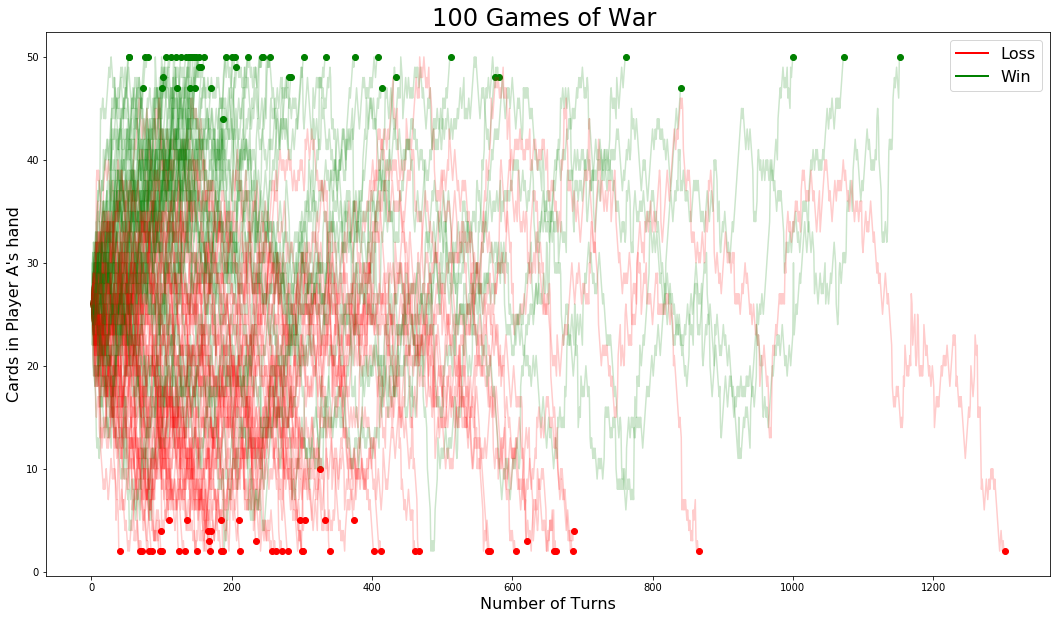

In [11]:
plot_wins_vs_losses(games_and_results, num_games=100, linealpha=.2);

Now, let's look the first *thousand* games. One thing I want to point out is the last argument in my plotting call, `linealpha=.1`. This essentially means that every line that gets plotted on the figure is about 90% see-though.

So when the first ~500 turns are basically a mess of solidly-colored red and green you're seeing the result of many, many overlapping games and outcomes.

Furthermore, if you notice the x-axis difference between this and the last post, we've stumbled across games that go on for **2,000+ turns**, which is just bananas.

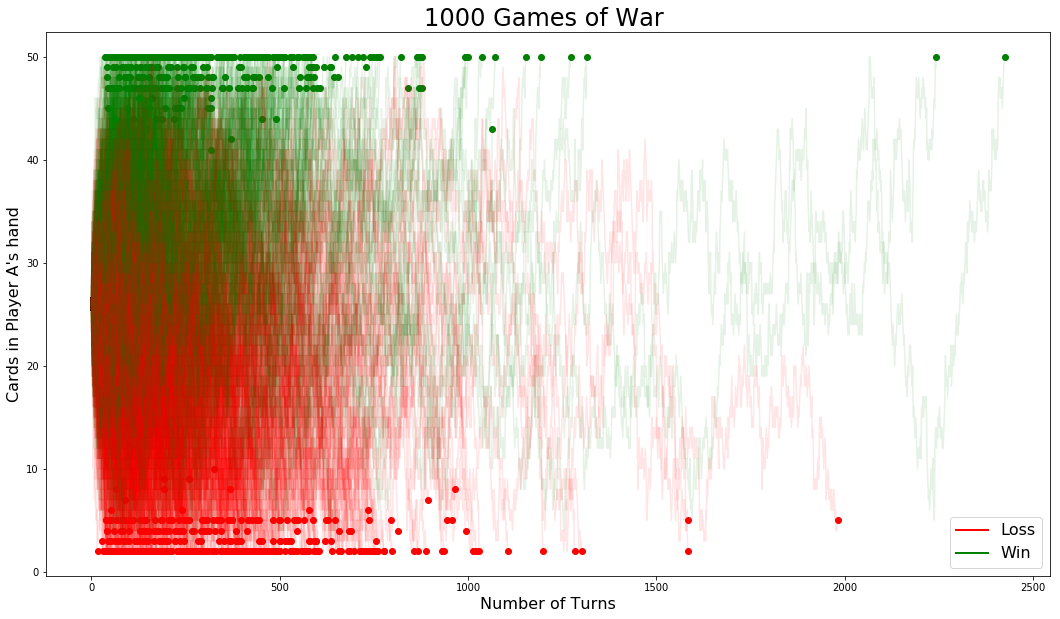

In [13]:
plot_wins_vs_losses(games_and_results, num_games=1000, linealpha=.1);

And then ten thousand games, because why not?

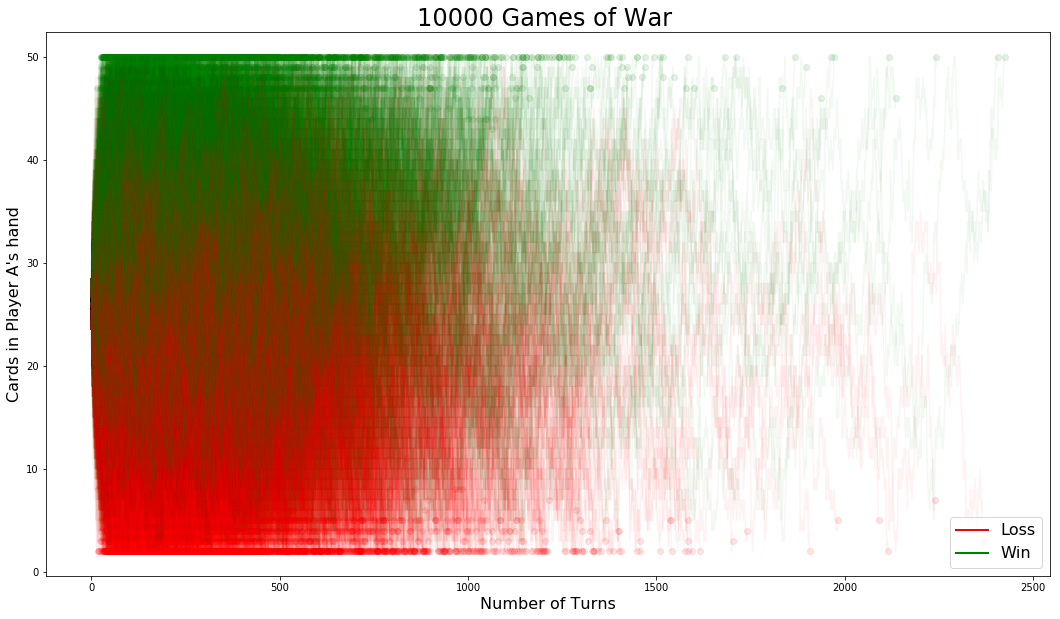

In [42]:
plot_wins_vs_losses(games_and_results, 10000, .05, .1);

All told, the win rate between players A and B were about even, as one might expect!

In [43]:
results['a_won'].value_counts()

False    50168
True     49832
Name: a_won, dtype: int64

(Editor's note: I was excited to be done writing the simulator and sat down to write this post over a week ago, only to find that I had closer to a 70/30 win loss ratio. Not an ideal way to learn that your code was wrong, haha)

### Estimated Playtime

You have been shocked to see how long some of the games from the last section dragged out. I sure was.

If each game was represented by its own text file, and each turn a line in said files, finding the duration of any game was just a matter of doing a line count.

In [ ]:
lengths = get_game_lengths()

The distribution is pretty skewed by outliars, but it looks like you can bank on most of your games being less than 500 turns.

In [ ]:
lengths['turns'].hist(bins=100, figsize=(18, 10));

Upon closer inspection, half of your games will come in at 241 or less.

In [ ]:
lengths['turns'].describe()

But what does that mean?

Let's assume that, ignoring the additional time it takes to resolve a war, it takes 2 seconds to run a turn (I think it's longer, but hey, round numbers...)

That means that you're spending, on average, 8 minutes just going through the motions.

In [ ]:
(241  # average game length
 * 2  # seconds per turn
 / 60 # seconds a minute
)

Extrapolating, say you only had 15 minutes and so you were stuck between the decision of playing a game of War or doing literally anything else. You'd need the game to wrap up in less than 450 turns.

In [ ]:
(15    # desired minutes
 * 60  # seconds a minute
 / 2   # seconds a turn
)

Or everything to the left of the red line.

In [ ]:
lengths['turns'].hist(bins=100, figsize=(18, 10)).axvline(450, color='r');

A little shy of 80% of the games that you play

In [ ]:
len(lengths[lengths['turns'] <= 450]) / len(lengths)

By the by, [BoardGameGeek has this game coming in at about a 30 minute playtime.](https://boardgamegeek.com/boardgame/16398/war)

### War Begets More War

One of the more interesting interactions I found in the data was the relationship between the number of times players went to war and the number of turns the game stretched out.

No headscratching whatsoever that there was a positive relationship between the two, but I didn't expect to see such a steady, *linear* relationship.

In [ ]:
temp = (whole_games.groupby('game')['wars'].sum()
        .to_frame().merge(lengths, left_index=True, right_on='game'))
 
fig, ax = plt.subplots(figsize=(18, 10))
ax.scatter(temp['turns'], temp['wars'], alpha=.5)
ax.set_xlabel('Number of Turns', fontsize=16)
ax.set_ylabel('Number of Wars', fontsize=16);

I was pretty blown away the correlation coefficient, if anyone cares to see it

In [ ]:
temp.corr()['turns']['wars']

As I mentioned above, each number in the `wars` column represents the number of times the players went to war *on that turn*. And so filtering out all of the normal, non-war turns, we can see the distribution of back-to-back wars on turns that had any at all.

In [ ]:
a = whole_games[whole_games['wars'] != 0]['wars']
a.value_counts(normalize=True)

Similarly, we can see the highest number of consecutive wars in each game

In [ ]:
whole_games.groupby('game')['wars'].max().value_counts().sort_index()

Wait, there was a turn with **six consecutive wars??**

In [ ]:
whole_games[whole_games['wars'] == 6]

Looks like it occurs at index `1960806` in our big table. Let's look a few turns before and after that.

In [ ]:
whole_games.loc[1960804:1960810]

Oh, man. The `game` column increments in the very next row. These 6 wars were what closed out the game.

In [ ]:
ax = plot_game_history(15118)

Lol, get rekt

## When to Pack it Up?

To the extent that the answer isn't "right away, always" my main goal in writing this post is to develop some intuition for when you could pretty much call a game.

As we saw above, I observed about a 50/50 win rate per player across the hundred-thousand games I simulated. But suppose you were paying attention the the cards that you saw, what inferences could you make about how the game would play out?

### Win the Battle, Win the War?

One of the first things that was brought to my attention (and trickiest to code...) was logging whether or not Player A had more cards than Player B by the time both players reached the bottom of their 26 cards and shuffled for the first time.

Like the "A won the whole game" ratio, there was a pretty even distribution of values here as well.

In [ ]:
results.groupby(['a_won_first_round']).size()

Makes enough sense that that'd be even. Might also be immediately agreeable that the notion of "winning the first battles means you're more likely to win the war" holds water.

In [ ]:
results.groupby(['a_won', 'a_won_first_round']).size().unstack()

We saw A's change of winning increase from a coin flip to almost 2/3

In [ ]:
results.groupby('a_won_first_round')['a_won'].mean()

### Stack the Deck

More compelling, was looking at the games through the lens of "How many Aces did each player start with?"

I loaded up ALL of the games I'd simulated, then trimmed that dataset down to just games where Player A started a game with 4 aces in hand.

In [ ]:
whole_games = load_whole_games()
temp = whole_games.merge(results, on='game')
four_ace_game = temp[(temp['a_starting_aces'] == 4)]

This wound up being about five and a half thousand of my games

In [ ]:
four_ace_game['game'].nunique()

Using the same plots as above, there's a clear difference looking at these games. Not only is there a stark imbalance between Wins and Losses, the games are much shorter.

In [ ]:
plot_wins_vs_losses(four_ace_game, 1000, linealpha=.1,
                    markeralpha=.1, xlim=[0, 1000],
                    additional_title='when Player A Starts with 4 Aces');

But this doesn't quite tell the whole story.

Instead, we'll plot *every* 4-Aces-for-Player-A game and change the line transparency from 90%, to **99%**.

In [ ]:
plot_wins_vs_losses(four_ace_game, 5570, linealpha=.01,
                    markeralpha=.01, xlim=[0, 1000],
                    additional_title='when Player A Starts with 4 Aces');

In [27]:
len(results)

100000

In [28]:
results.groupby('a_starting_aces')['a_won'].mean()

a_starting_aces
0    0.174014
1    0.333705
2    0.497098
3    0.665402
4    0.831059
Name: a_won, dtype: float64

In [29]:
results.groupby('a_starting_aces').size()

a_starting_aces
0     5580
1    25127
2    38944
3    24779
4     5570
dtype: int64

In [30]:
gb = results.groupby(['a_starting_aces', 'a_starting_kings'])['a_won']

In [31]:
wins_by_starts = gb.mean().unstack()
wins_by_starts

a_starting_kings,0,1,2,3,4
a_starting_aces,,,,,
0,0.054795,0.116860,0.169111,0.214628,0.258974
1,0.232432,0.276803,0.334432,0.377011,0.414605
2,0.382646,0.453333,0.498350,0.544873,0.589559
3,0.576875,0.626438,0.670185,0.712605,0.745599
4,0.782407,0.793765,0.843165,0.866372,0.916667


In [32]:
counts_by_starts = gb.count().unstack()
counts_by_starts

a_starting_kings,0,1,2,3,4
a_starting_aces,,,,,
0,219,1121,2182,1668,390
1,1110,5755,9706,6899,1657
2,2109,9750,15459,9538,2088
3,1600,6778,9569,5696,1136
4,432,1668,2136,1130,204


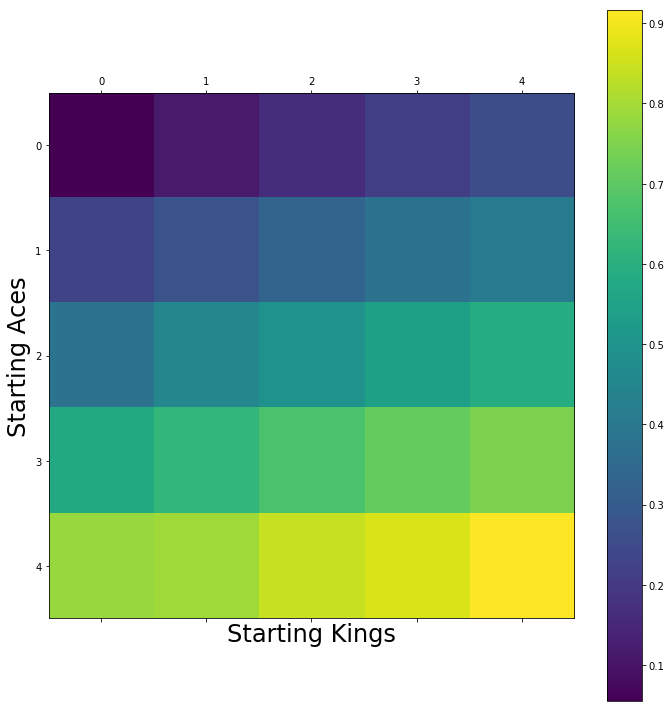

In [33]:
starting_cards_heatmap(wins_by_starts);

## High/Low-Lights

In [34]:
results = results.merge(lengths)

### The Thrill of Victory

In [35]:
interesting_wins = results[(results['a_starting_aces'] == 0)
                           & (results['a_starting_kings'] == 0)
                           & (results['a_won'] == True)]
interesting_wins

,game,a_starting_aces,a_starting_kings,a_won,a_won_first_round,turns
7289,16558,0,0,True,False,324
21014,28910,0,0,True,False,384
22282,30050,0,0,True,False,210
32896,39604,0,0,True,False,975
46834,52148,0,0,True,False,269
48700,53828,0,0,True,False,721
53270,57941,0,0,True,False,399
59993,63992,0,0,True,False,765
67711,70938,0,0,True,False,240
69862,72874,0,0,True,False,339


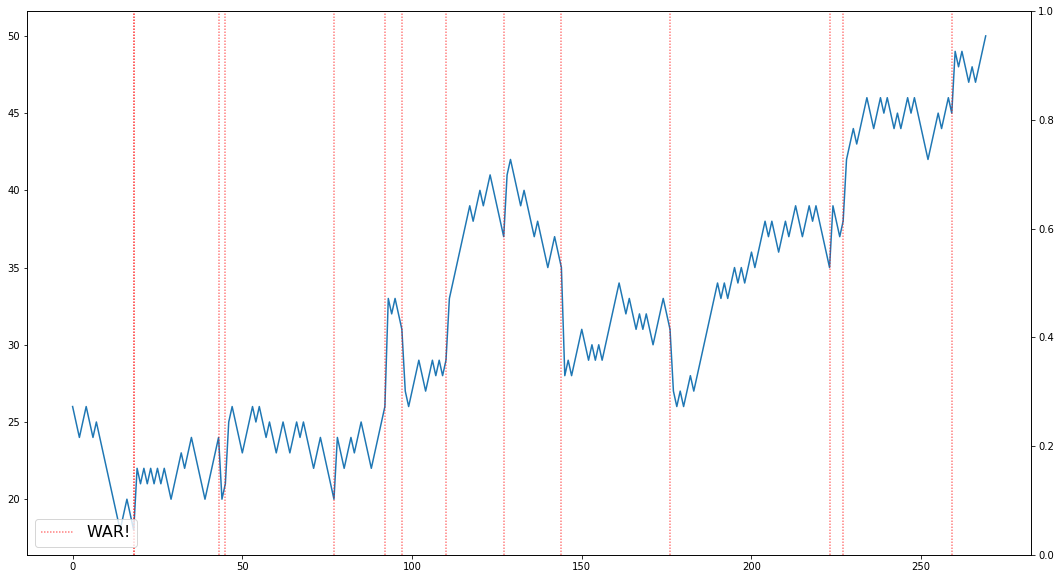

In [36]:
ax = plot_game_history(52148)

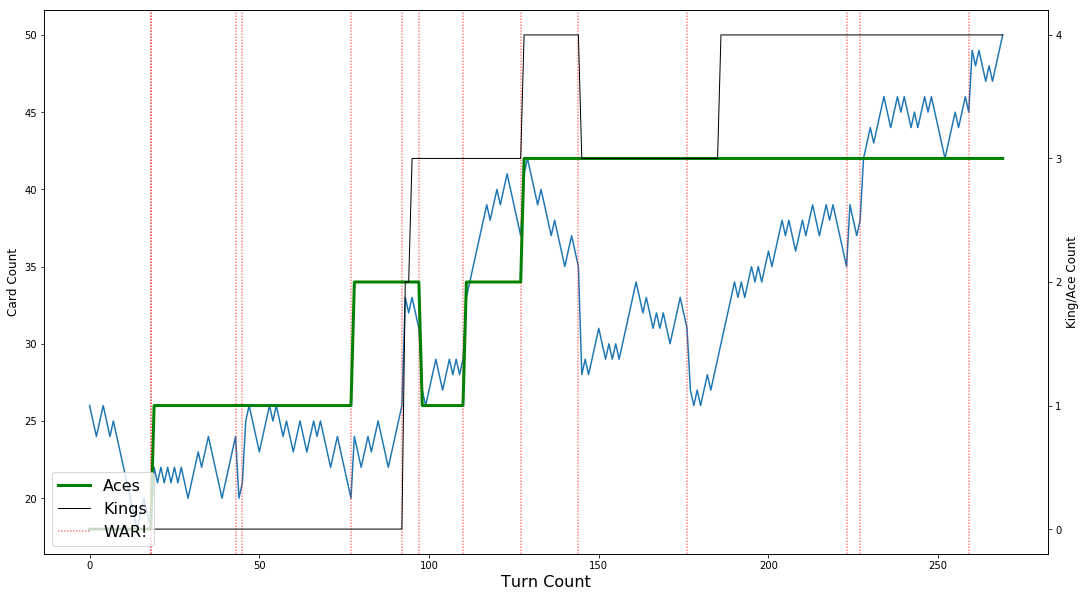

In [37]:
ax = plot_game_history(52148, aces_and_kings=True)

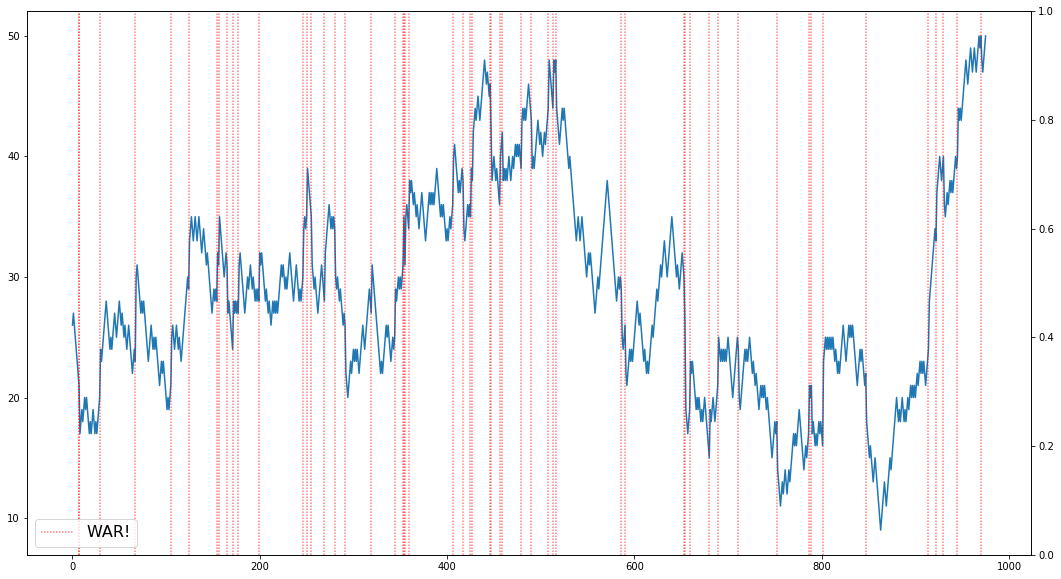

In [38]:
plot_game_history(39604);

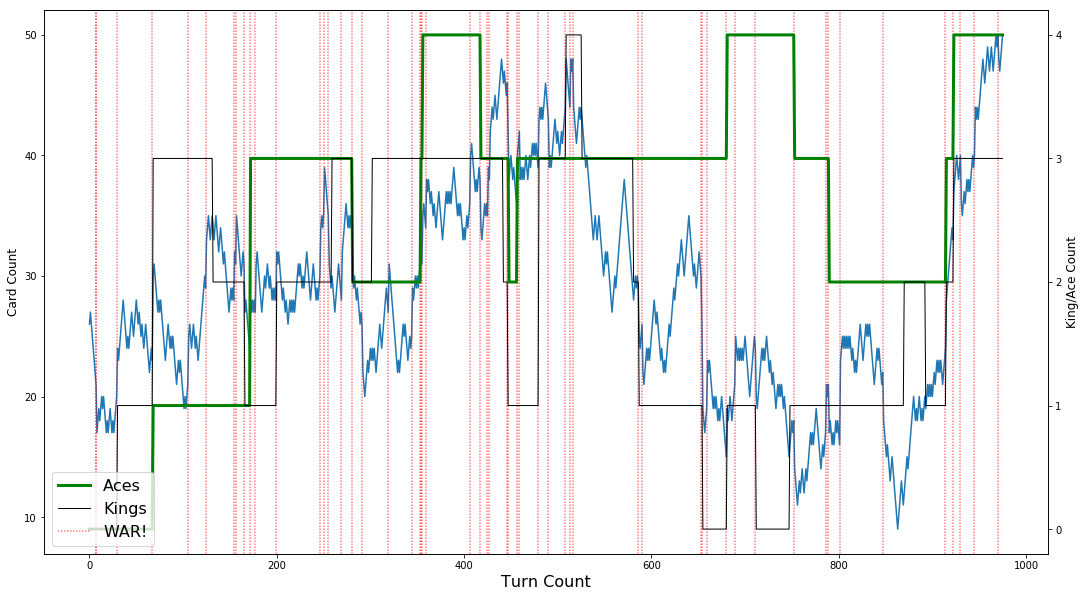

In [39]:
plot_game_history(39604, aces_and_kings=True);

### The Agony of Defeat

In [40]:
interesting_losses = results[(results['a_starting_aces'] == 4) & (results['a_starting_kings'] == 4)
                             & (results['a_won'] == False)]
interesting_losses.merge(lengths)

,game,a_starting_aces,a_starting_kings,a_won,a_won_first_round,turns
0,15207,4,4,False,True,689
1,26007,4,4,False,False,243
2,28449,4,4,False,True,732
3,31479,4,4,False,True,949
4,33303,4,4,False,True,478
5,33521,4,4,False,True,394
6,34701,4,4,False,True,310
7,40859,4,4,False,True,403
8,41398,4,4,False,True,733
9,44944,4,4,False,True,487


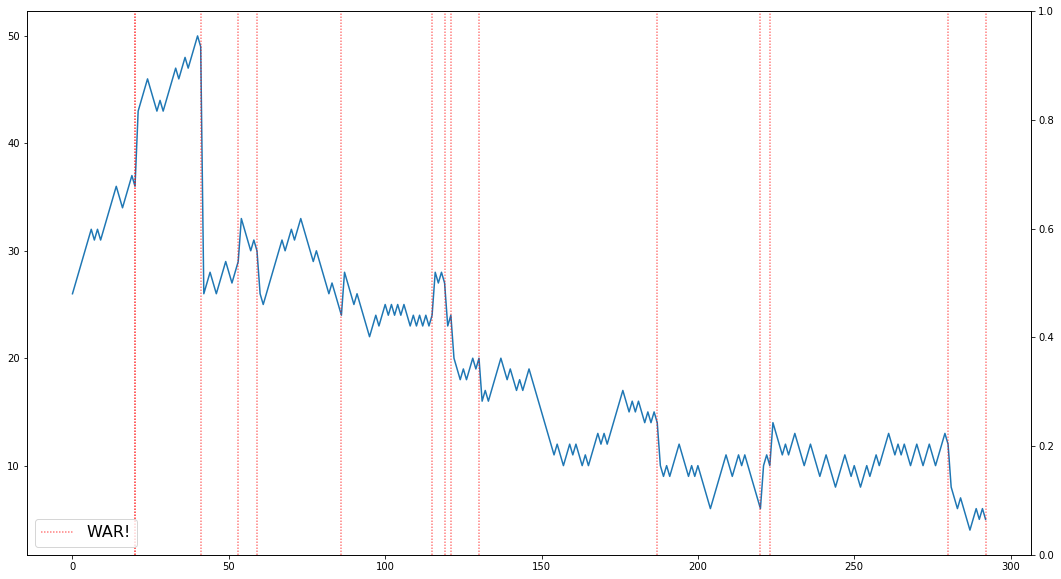

In [41]:
plot_game_history(980);

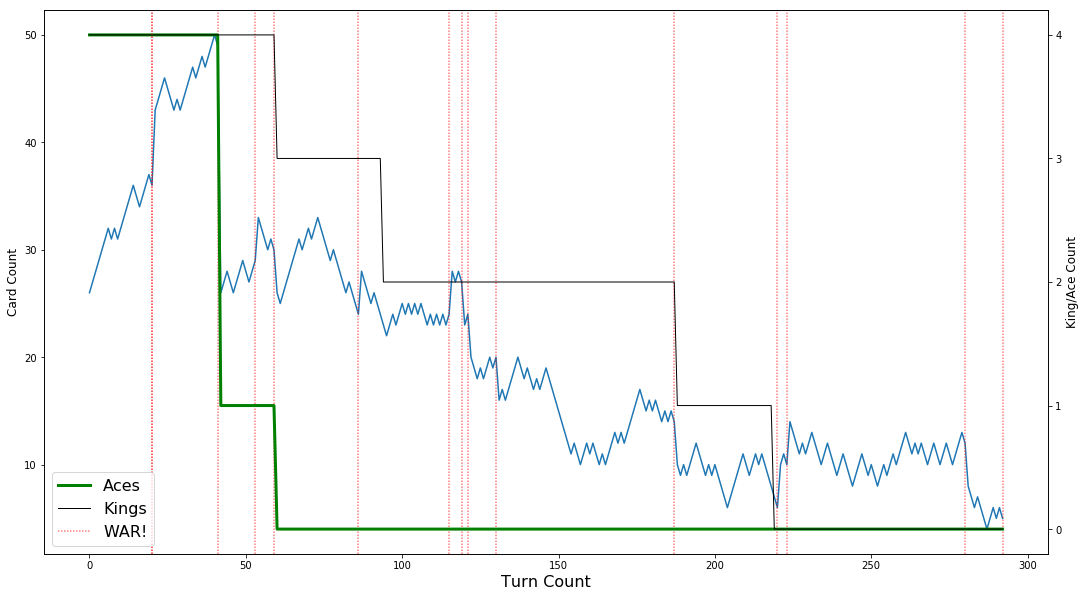

In [42]:
plot_game_history(980, aces_and_kings=True);

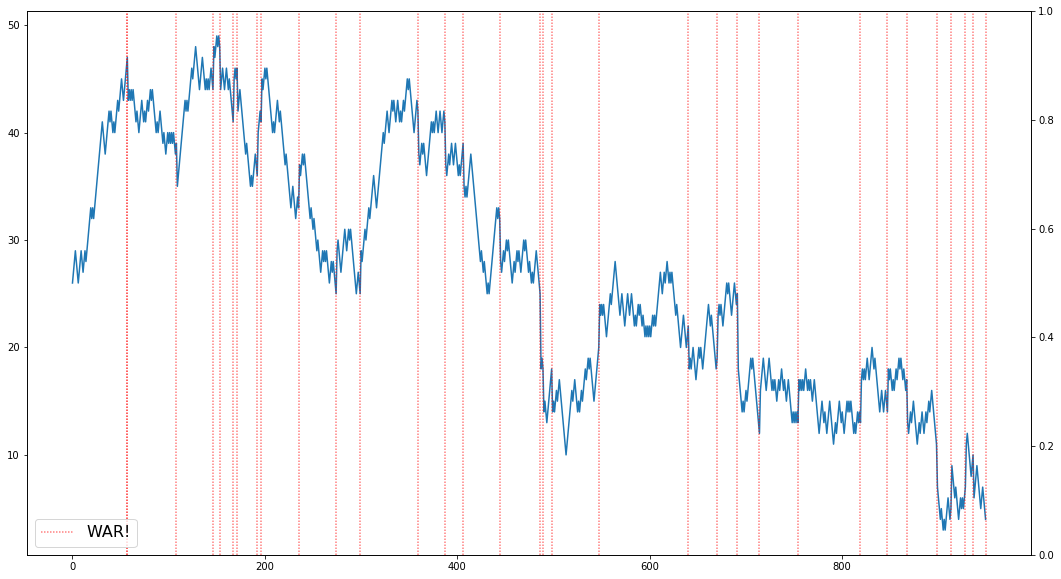

In [43]:
plot_game_history(31479);

## Conclusion

Counterpoint, this kind of thing happens less than 0.03% of the time.

In [44]:
(len(interesting_losses) + len(interesting_wins)) / 100000

0.00029